In [1]:
import maboss
import numpy as np
import pandas as pd
from tools import load_trajs, draw_graph_from_pandas, compute_circuits

In [2]:
outputs =["CycA", "CycB", "CycE"]

In [3]:
sim = maboss.load("cellcycle.bnd", "cellcycle_runcfg.cfg")
sim.network.set_output(outputs)

In [4]:
%time res = sim.run(workdir="sim")

CPU times: user 2.54 ms, sys: 12 ms, total: 14.5 ms
Wall time: 23.4 s


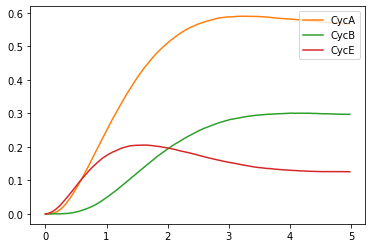

In [5]:
res.plot_node_trajectory()

If we want to study oscillations in MaBoSS, we are faced with this issue : the trajectories are not synchronized, so the average converges very quickly

In [6]:
sim_discrete = sim.copy()

sim_discrete.param["discrete_time"] = 1
sim_discrete.param['time_tick'] = 1
sim_discrete.param['max_time'] = 100

In [7]:
%time res_discrete = sim_discrete.run(workdir="sim_discrete")

CPU times: user 11.5 ms, sys: 16.8 ms, total: 28.3 ms
Wall time: 1min 13s


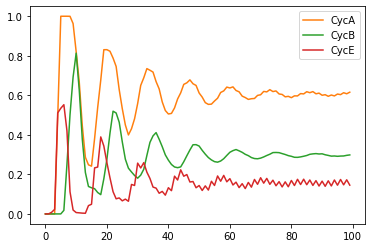

In [8]:
res_discrete.plot_node_trajectory()

If we remote the continuous time, it get's slightly better : we remove one source of desynchronization, the random transition time, but the the random branch choice in the STG.

It's still good enough to see the sequence CycE -> CycA -> CycB

Here we decide to look at individual trajectories to study these cycles.

We need two settings to activate the individual trajectories output : 
- display_traj = 1
- thread_count = 1 (export is not working in multi-thread mode)

And we choose a discrete time, as this analysis doesn't care about coutinuous time.

The number of transitions is the number of time_ticks in max_time, we choose 50 as it should ensures at least 4 cycles

In [9]:
sim_trajs = sim.copy()

sim_trajs.param["display_traj"] = 1
sim_trajs.param["thread_count"] = 1

sim_trajs.param["discrete_time"] = 1
sim_trajs.param["max_time"] = 50
sim_trajs.param["time_tick"] = 1

In [10]:
%time res_trajs = sim_trajs.run(workdir="sim_trajectories")

CPU times: user 0 ns, sys: 19.9 ms, total: 19.9 ms
Wall time: 1min 25s


Now we need to load the individual trajectories, as this is not implemented in pyMaBoSS yet

Note that the individual trajectories print all nodes, so here we set an output list to remove the other nodes

In [11]:
%time trajs, all_states = load_trajs(res_trajs._path, outputs)

CPU times: user 35.6 s, sys: 1.18 s, total: 36.8 s
Wall time: 36.8 s


We obtain the sequence of states in each trajectory (a list of lists)

Here, we first count the total number for each transition in the trajectories

In [12]:
state_ids = {state:ind for ind, state in enumerate(sorted(list(all_states))) }
ids_state = {ind:state for ind, state in enumerate(sorted(list(all_states))) }
stg_counts = np.zeros((len(all_states), len(all_states)))
for i, t_traj in enumerate(trajs):
    for j, t_state in enumerate(t_traj):
        if j > 0:
            stg_counts[state_ids[t_traj[j-1]], state_ids[t_state]] += 1
            
data = pd.DataFrame(
    data=stg_counts,
    index=state_ids.keys(), columns=state_ids.keys()
)
data

,<nil>,CycA,CycA -- CycB,CycA -- CycB -- CycE,CycA -- CycE,CycB,CycB -- CycE,CycE
<nil>,0.0,368489.0,0.0,0.0,0.0,9410.0,0.0,383244.0
CycA,230284.0,0.0,794738.0,0.0,31598.0,0.0,0.0,0.0
CycA -- CycB,0.0,390058.0,0.0,1198.0,0.0,388634.0,0.0,0.0
CycA -- CycB -- CycE,0.0,0.0,39542.0,0.0,2023.0,0.0,2052.0,0.0
CycA -- CycE,0.0,348129.0,0.0,43847.0,0.0,0.0,0.0,706.0
CycB,385053.0,0.0,73.0,0.0,0.0,0.0,91.0,0.0
CycB -- CycE,0.0,0.0,0.0,18.0,0.0,936.0,0.0,1214.0
CycE,1222.0,0.0,0.0,0.0,383204.0,0.0,128.0,0.0


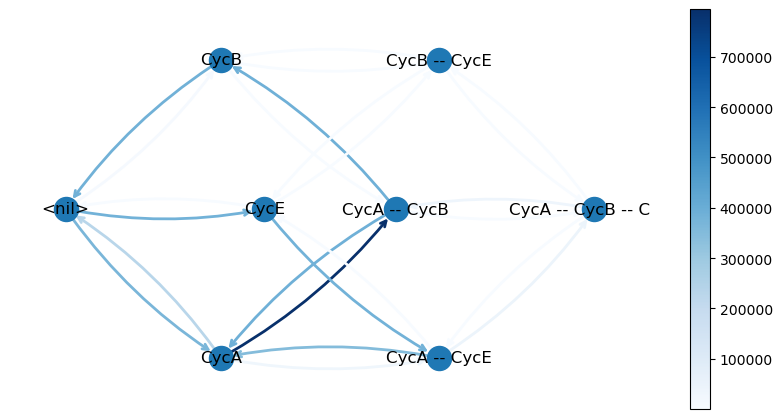

In [13]:
draw_graph_from_pandas(data)

Here we see a kind of "occupancy" of the STG, with some parts barely explored

We then compute a normalized version of the transition graph, where values will correspond to the probability of the next transition

In [14]:
probas = pd.DataFrame(
    data=np.divide(stg_counts,stg_counts.sum(axis=1)[:, np.newaxis]), 
    index=state_ids.keys(), columns=state_ids.keys()
)
probas

,<nil>,CycA,CycA -- CycB,CycA -- CycB -- CycE,CycA -- CycE,CycB,CycB -- CycE,CycE
<nil>,0.000000,0.484126,0.000000,0.000000,0.000000,0.012363,0.000000,0.503511
CycA,0.217944,0.000000,0.752151,0.000000,0.029905,0.000000,0.000000,0.000000
CycA -- CycB,0.000000,0.500145,0.000000,0.001536,0.000000,0.498319,0.000000,0.000000
CycA -- CycB -- CycE,0.000000,0.000000,0.906573,0.000000,0.046381,0.000000,0.047046,0.000000
CycA -- CycE,0.000000,0.886542,0.000000,0.111660,0.000000,0.000000,0.000000,0.001798
CycB,0.999574,0.000000,0.000190,0.000000,0.000000,0.000000,0.000236,0.000000
CycB -- CycE,0.000000,0.000000,0.000000,0.008303,0.000000,0.431734,0.000000,0.559963
CycE,0.003178,0.000000,0.000000,0.000000,0.996489,0.000000,0.000333,0.000000


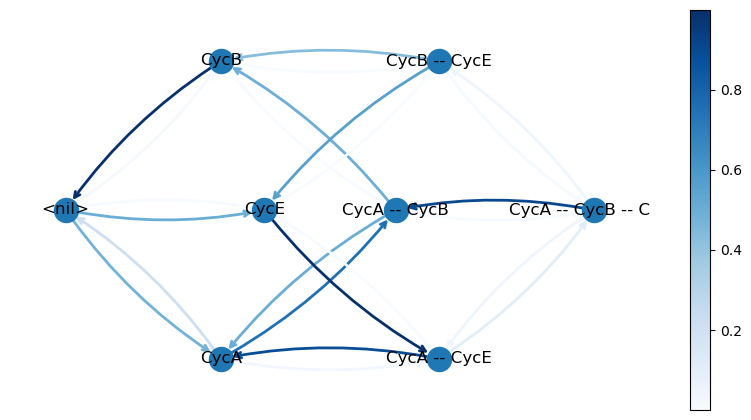

In [15]:
draw_graph_from_pandas(probas)

Here the values of the nodes correspond to probability of the next transition.

Now we compute the most likely circuits, with their respectives probabilities. Here we can have loops within the circuits, so at first we ignore them

In [16]:
%time paths_dict = compute_circuits(probas, ids_state, '<nil>', 0)

CPU times: user 109 ms, sys: 3.86 ms, total: 112 ms
Wall time: 112 ms


In [17]:
for proba in sorted(paths_dict, reverse=True):
    if proba > 0.01:
        print("%.2f : %s" % (proba, paths_dict[proba]))

0.18 : ['<nil>', 'CycA', 'CycA -- CycB', 'CycB']
0.17 : ['<nil>', 'CycE', 'CycA -- CycE', 'CycA', 'CycA -- CycB', 'CycB']
0.11 : ['<nil>', 'CycA']
0.10 : ['<nil>', 'CycE', 'CycA -- CycE', 'CycA']
0.03 : ['<nil>', 'CycE', 'CycA -- CycE', 'CycA -- CycB -- CycE', 'CycA -- CycB', 'CycB']
0.01 : ['<nil>', 'CycB']


In [18]:
print("By removing all loops, we are removing at %.2g%% of observed circuits" % (100.0*sum(paths_dict.keys())))

By removing all loops, we are removing at 60% of observed circuits


We check how different the result are with at list one loop allowed within the circuits

In [19]:
%time paths_dict_oneloop = compute_circuits(probas, ids_state, '<nil>', 1)

CPU times: user 15.8 s, sys: 59.4 ms, total: 15.8 s
Wall time: 15.8 s


In [20]:
for proba in sorted(paths_dict_oneloop, reverse=True):
    if proba > 0.01:
        print("%.2f : %s" % (proba, paths_dict_oneloop[proba]))

0.18 : ['<nil>', 'CycA', 'CycA -- CycB', 'CycB']
0.17 : ['<nil>', 'CycE', 'CycA -- CycE', 'CycA', 'CycA -- CycB', 'CycB']
0.11 : ['<nil>', 'CycA']
0.10 : ['<nil>', 'CycE', 'CycA -- CycE', 'CycA']
0.07 : ['<nil>', 'CycA', 'CycA -- CycB', 'CycA', 'CycA -- CycB', 'CycB']
0.06 : ['<nil>', 'CycE', 'CycA -- CycE', 'CycA', 'CycA -- CycB', 'CycA', 'CycA -- CycB', 'CycB']
0.04 : ['<nil>', 'CycA', 'CycA -- CycB', 'CycA']
0.04 : ['<nil>', 'CycE', 'CycA -- CycE', 'CycA', 'CycA -- CycB', 'CycA']
0.03 : ['<nil>', 'CycE', 'CycA -- CycE', 'CycA -- CycB -- CycE', 'CycA -- CycB', 'CycB']
0.01 : ['<nil>', 'CycB']


In [21]:
print("By removing circuits with more than one loop, we are removing at %.2g%% of observed circuits" % (100.0*sum(paths_dict_oneloop.keys())))

By removing circuits with more than one loop, we are removing at 84% of observed circuits
